In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.fft import * 
from util.phantom import * 
from util.coil import * 
from util.tool import * 
import nibabel as nib
import os
from tqdm.notebook import tqdm

In [2]:
import scipy.io
def get_tissue_images(slices):
    tissuetype = ['graymatter', 'deep_graymatter', 'whitematter', 'csf']
    T2 = [110, 100, 60, 1500]
    T2s = [40, 45, 50, 1000]
    mat = scipy.io.loadmat('../lib/resource/data/tissue_images/tissue_images.mat')
    tissues = mat.get("tissue_images")[:,:,slices,:]
    return np.squeeze(tissues), tissuetype

def brain_tissue(slices, coils):
    tissues,tissuetype = get_tissue_images(slices)
    if (coils== 1): return tissues,tissuetype, T2, T2s
    tissues = np.repeat(tissues[:, :,  np.newaxis,:], coils, axis=-2)
    coils = generate_birdcage_sensitivities(matrix_size = 222,number_of_coils = coils)
    tissues = tissues *  np.repeat(coils[...,np.newaxis], 4, axis = -1)
    return tissues,tissuetype
def sim_blip_up(ideal_image, field):
    ny, nx = ideal_image.shape
    image = np.zeros([ny, nx], dtype = complex)
    for y in range(ny-1,0,-1):
        modulation = np.exp(1j * t * field[ny-y])
        modulation = np.repeat(modulation[:,None], nx, -1)
        tmp = ideal_image * modulation 
        image[y] = fft2c(tmp)[y]
    extended = ifft2c(image)
    return extended
def sim_blip_down(ideal_image, field):
    ny, nx = ideal_image.shape
    image = np.zeros([ny, nx], dtype = complex)
    for y in range(ny):
        modulation = np.exp(1j * t * field[y])
        modulation = np.repeat(modulation[:,None], nx, -1)
        tmp = ideal_image * modulation 
        image[y] = fft2c(tmp)[y]
    contracted = ifft2c(image)
    return contracted

In [3]:
tissues,tissuetype = brain_tissue(70, 4)
ny, nx, nc, nt = tissues.shape
ns = 144

In [4]:
blip_up_data = np.zeros([ny,nx,ns])
blip_down_data = np.zeros([ny,nx,ns])
for sli in tqdm(range(ns)):
    tissues,tissuetype = brain_tissue(sli, 4)
    TE = 100
    ideal_image = np.zeros([ny, nx, nc], dtype = complex)
    for t in range(nt):
        ideal_image += tissues[...,t] * np.exp(TE/t2(tissuetype[t]))
    ideal_image = rsos(ideal_image) 
    G = 0.003
    fov = ny
    dwell_time = 1
    gamma = 2* np.pi * 42.58
    t = np.linspace(-1, 1, nx) * 1E-3 * fov
    phase_inc = gamma * G * dwell_time
    field = np.zeros([ny, nx], dtype = complex)
    for y in range(ny):
        field[y] =  phase_inc * y 
    blip_down_data[...,sli] = np.abs(sim_blip_down(ideal_image, field))
    blip_up_data[...,sli] = np.abs(sim_blip_up(ideal_image, field))

  0%|          | 0/144 [00:00<?, ?it/s]

In [5]:
for sli in range(ns):
    blip_up_data[...,sli] = blip_up_data[...,sli].T

In [6]:
for sli in range(ns):
    blip_down_data[...,sli] = blip_down_data[...,sli].T

In [7]:
path = "../lib/EPI_DISTORTION/"
if os.path.isdir(path) is False:
    os.mkdir(path)
%cd  ../lib/EPI_DISTORTION/

/home/zimu/Desktop/mri_recon/lib/EPI_DISTORTION


In [8]:
corrected = nib.load('merged.nii.gz').get_fdata()
print(corrected.shape)

(144, 222, 145, 2)


In [9]:
new_image = nib.Nifti1Image(blip_up_data, affine=np.eye(4))
nib.save(new_image,"blip_up.nii")
new_image = nib.Nifti1Image(blip_down_data, affine=np.eye(4))
nib.save(new_image, "blip_down.nii")
with open('acqparams.txt', 'w') as f:
    f.write('0 -1 0 '+str(10E-6*(ny-1)*nx)[:5])
    f.write('\n')
    f.write('0 1 0 '+str(10E-6*(ny-1)*nx)[:5])

In [10]:
merged_file = "merged"

In [11]:
os.system("fslmerge -t "+merged_file+".nii.gz blip_down.nii blip_up.nii")

0

In [12]:
os.system("topup --imain="+merged_file+" --datain=acqparams.txt --config=b02b0.cnf --out=topup_bfield")

0

In [13]:
os.system("applytopup --imain=blip_down,blip_up --topup=topup_bfield --datain=acqparams.txt --inindex=1,2 --out=fsl_corrected")

0

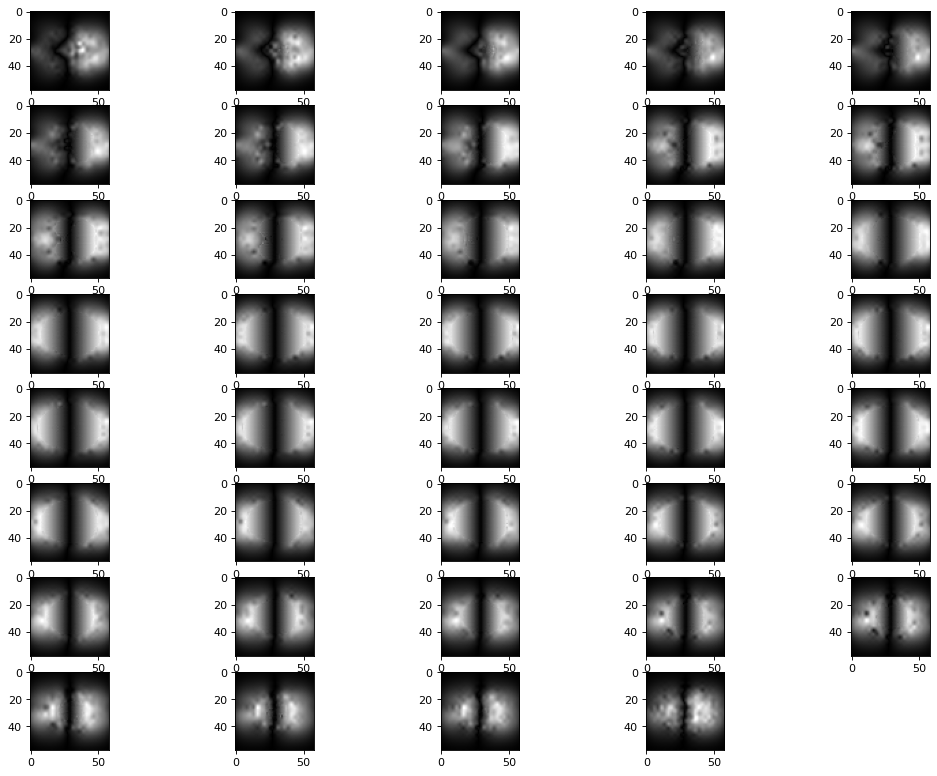

In [14]:
fieldmap = nib.load('topup_bfield_fieldcoef.nii.gz').get_fdata()
show(fieldmap)

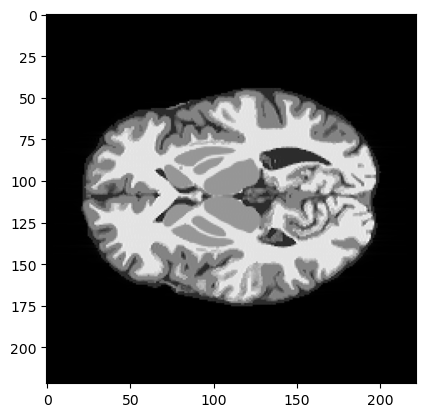

In [15]:
corrected = nib.load('fsl_corrected.nii.gz').get_fdata()
show(corrected[...,70])